In [6]:
import tables as tb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from labelling.MClabelling           import labelling_MC
from labelling.beershebalabelling    import labelling_beersheba
from utils.beersheba_labelling_utils import label_neighbours_ordered
from utils.data_utils                import get_event_id

from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits

In [2]:
cutnum, num = '24', '6206'
directory   = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'.format(cut = cutnum, num = num)

total_size  = (440, 440, 550) 
voxel_size  = (5, 5, 5) #equivalent to step
start_bin   = (-220, -220, 0) #equivalent to x0

In [3]:
labelled_MC_voxels, labelled_MC_hits = labelling_MC(directory, total_size, voxel_size, start_bin, blob_ener_loss_th = 0.25)
labelled_beersheba = labelling_beersheba(directory, 
                                         total_size, 
                                         voxel_size, 
                                         start_bin, 
                                         labelled_MC_voxels, 
                                         label_neighbours_ordered, 
                                         simple = True, 
                                         relabel = True)

In [9]:
nevent = 14

In [11]:
event_id = get_event_id(cutnum, nevent)

In [14]:
event_beersh = labelled_beersheba[labelled_beersheba.event_id == event_id]

In [16]:
event_hits = labelled_MC_hits[labelled_MC_hits.event_id == event_id]

<IPython.core.display.Javascript object>


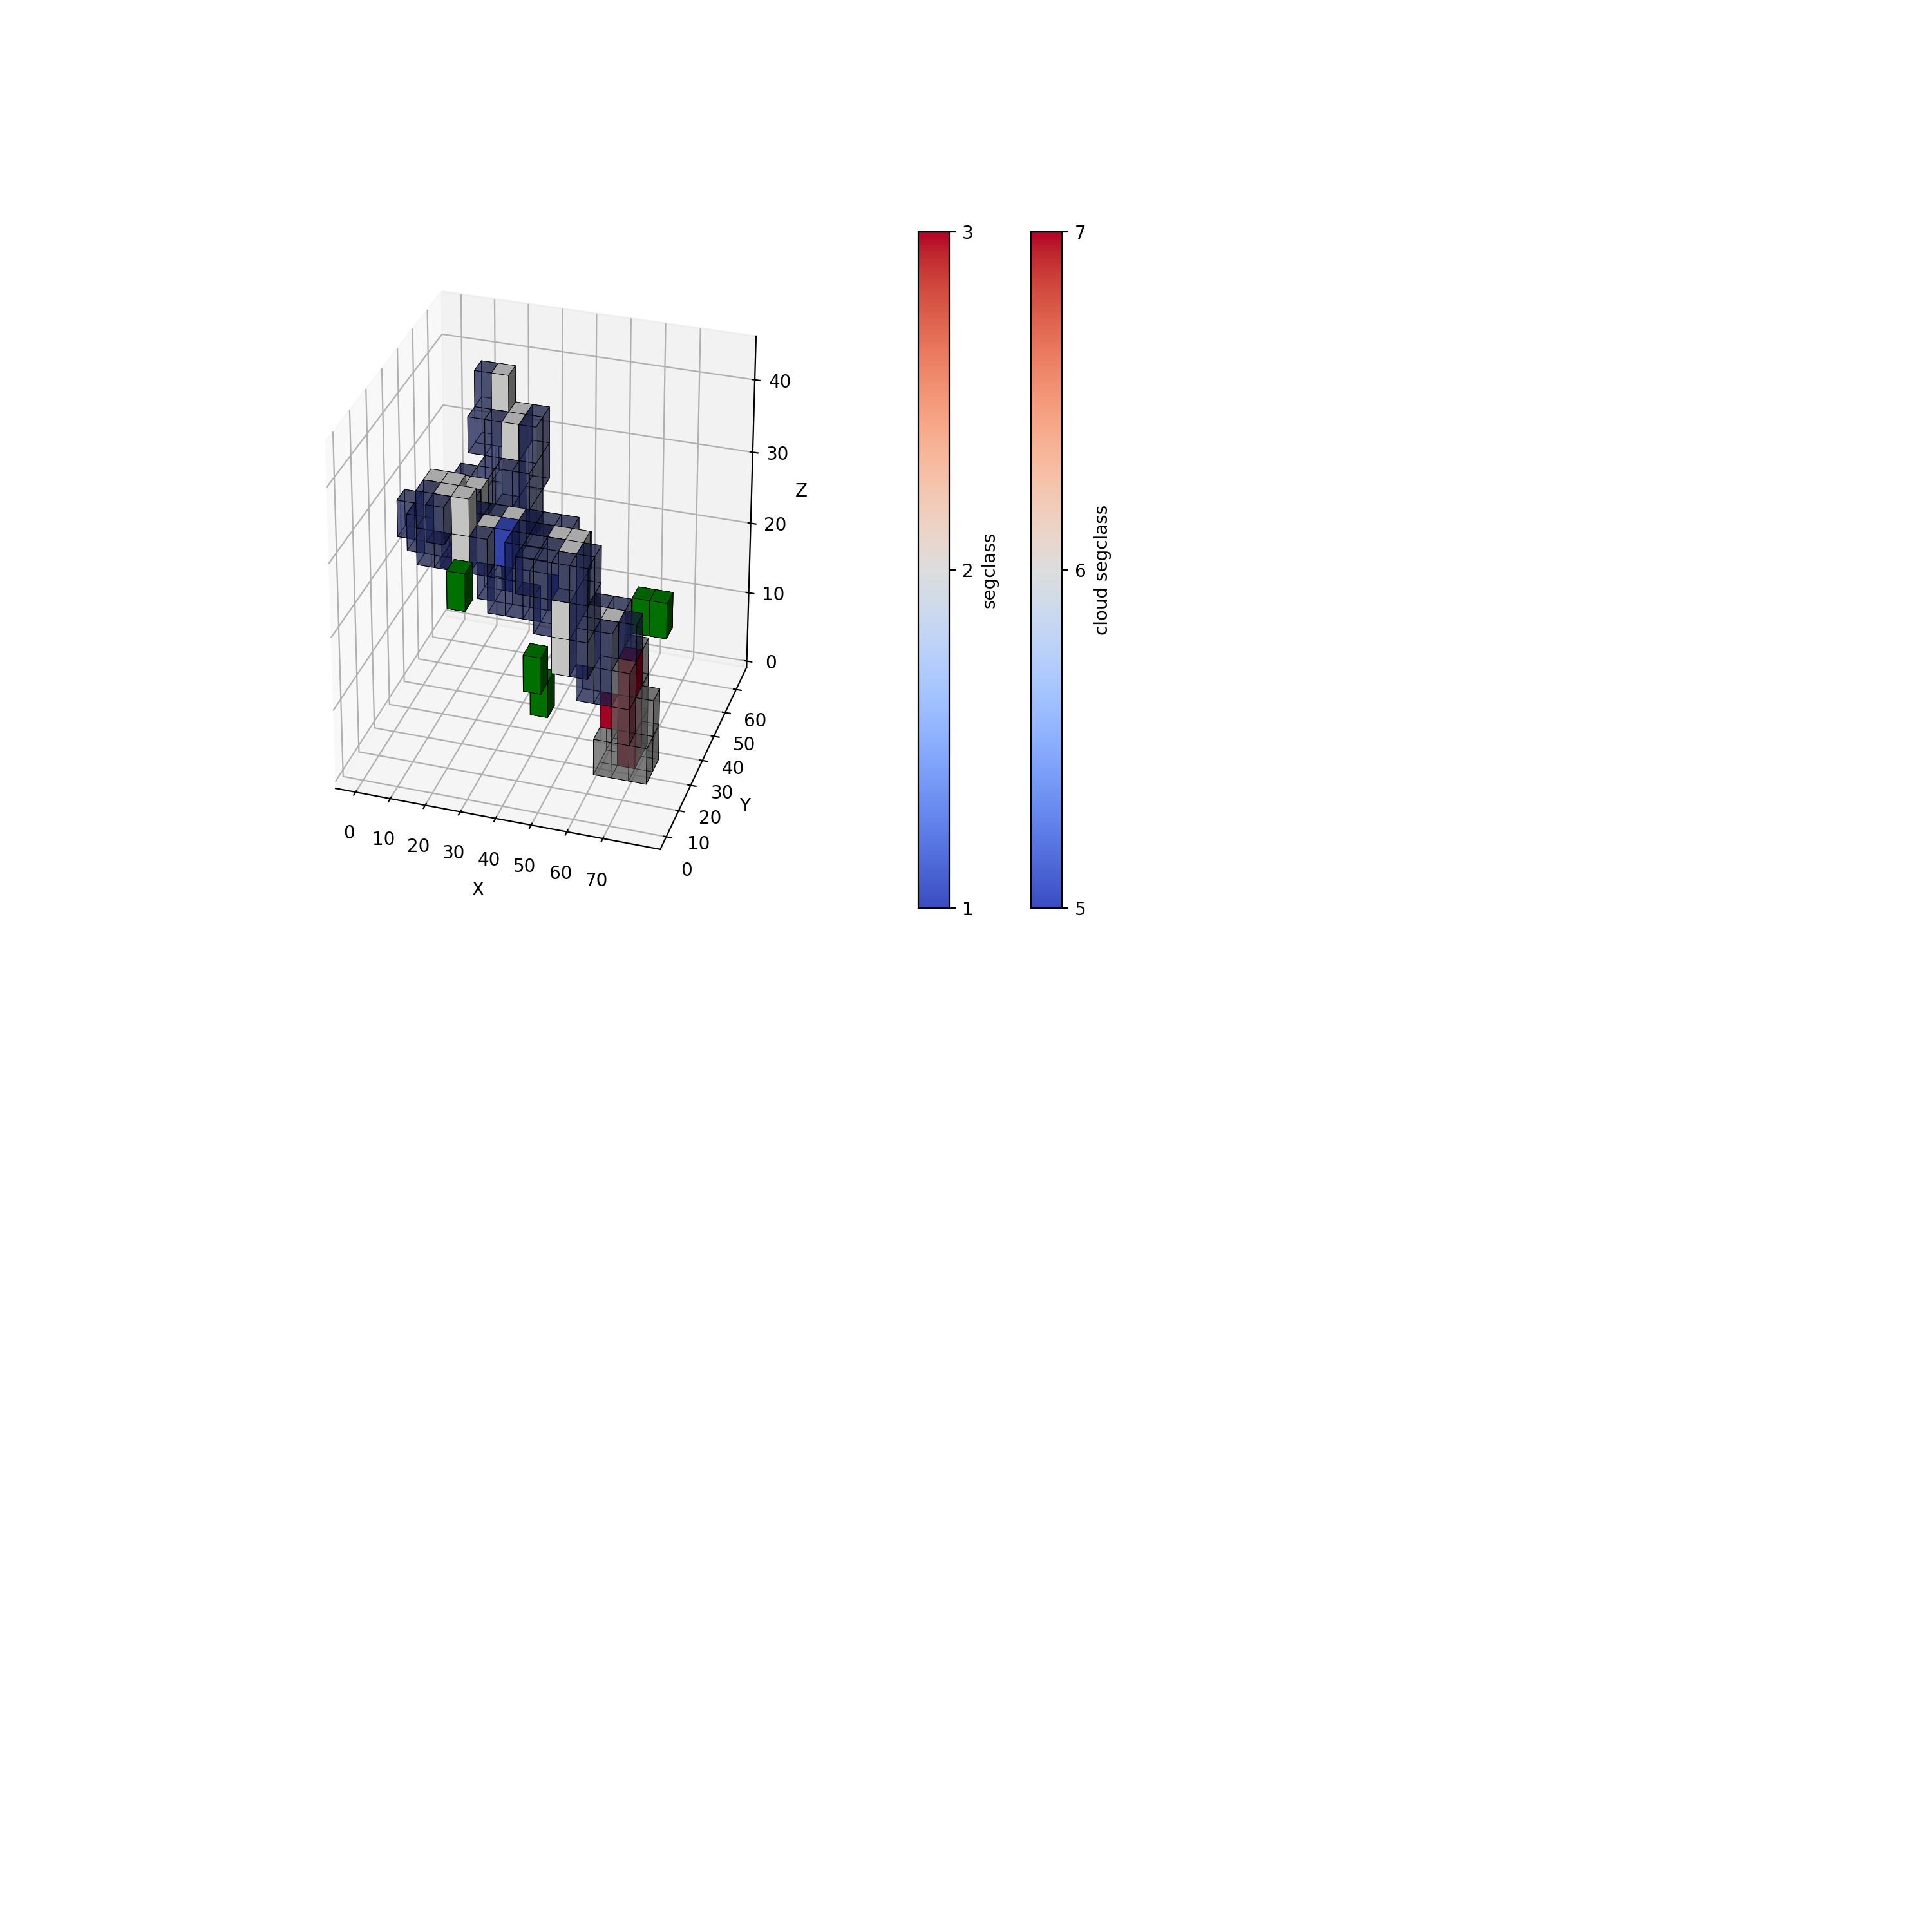

<IPython.core.display.Javascript object>


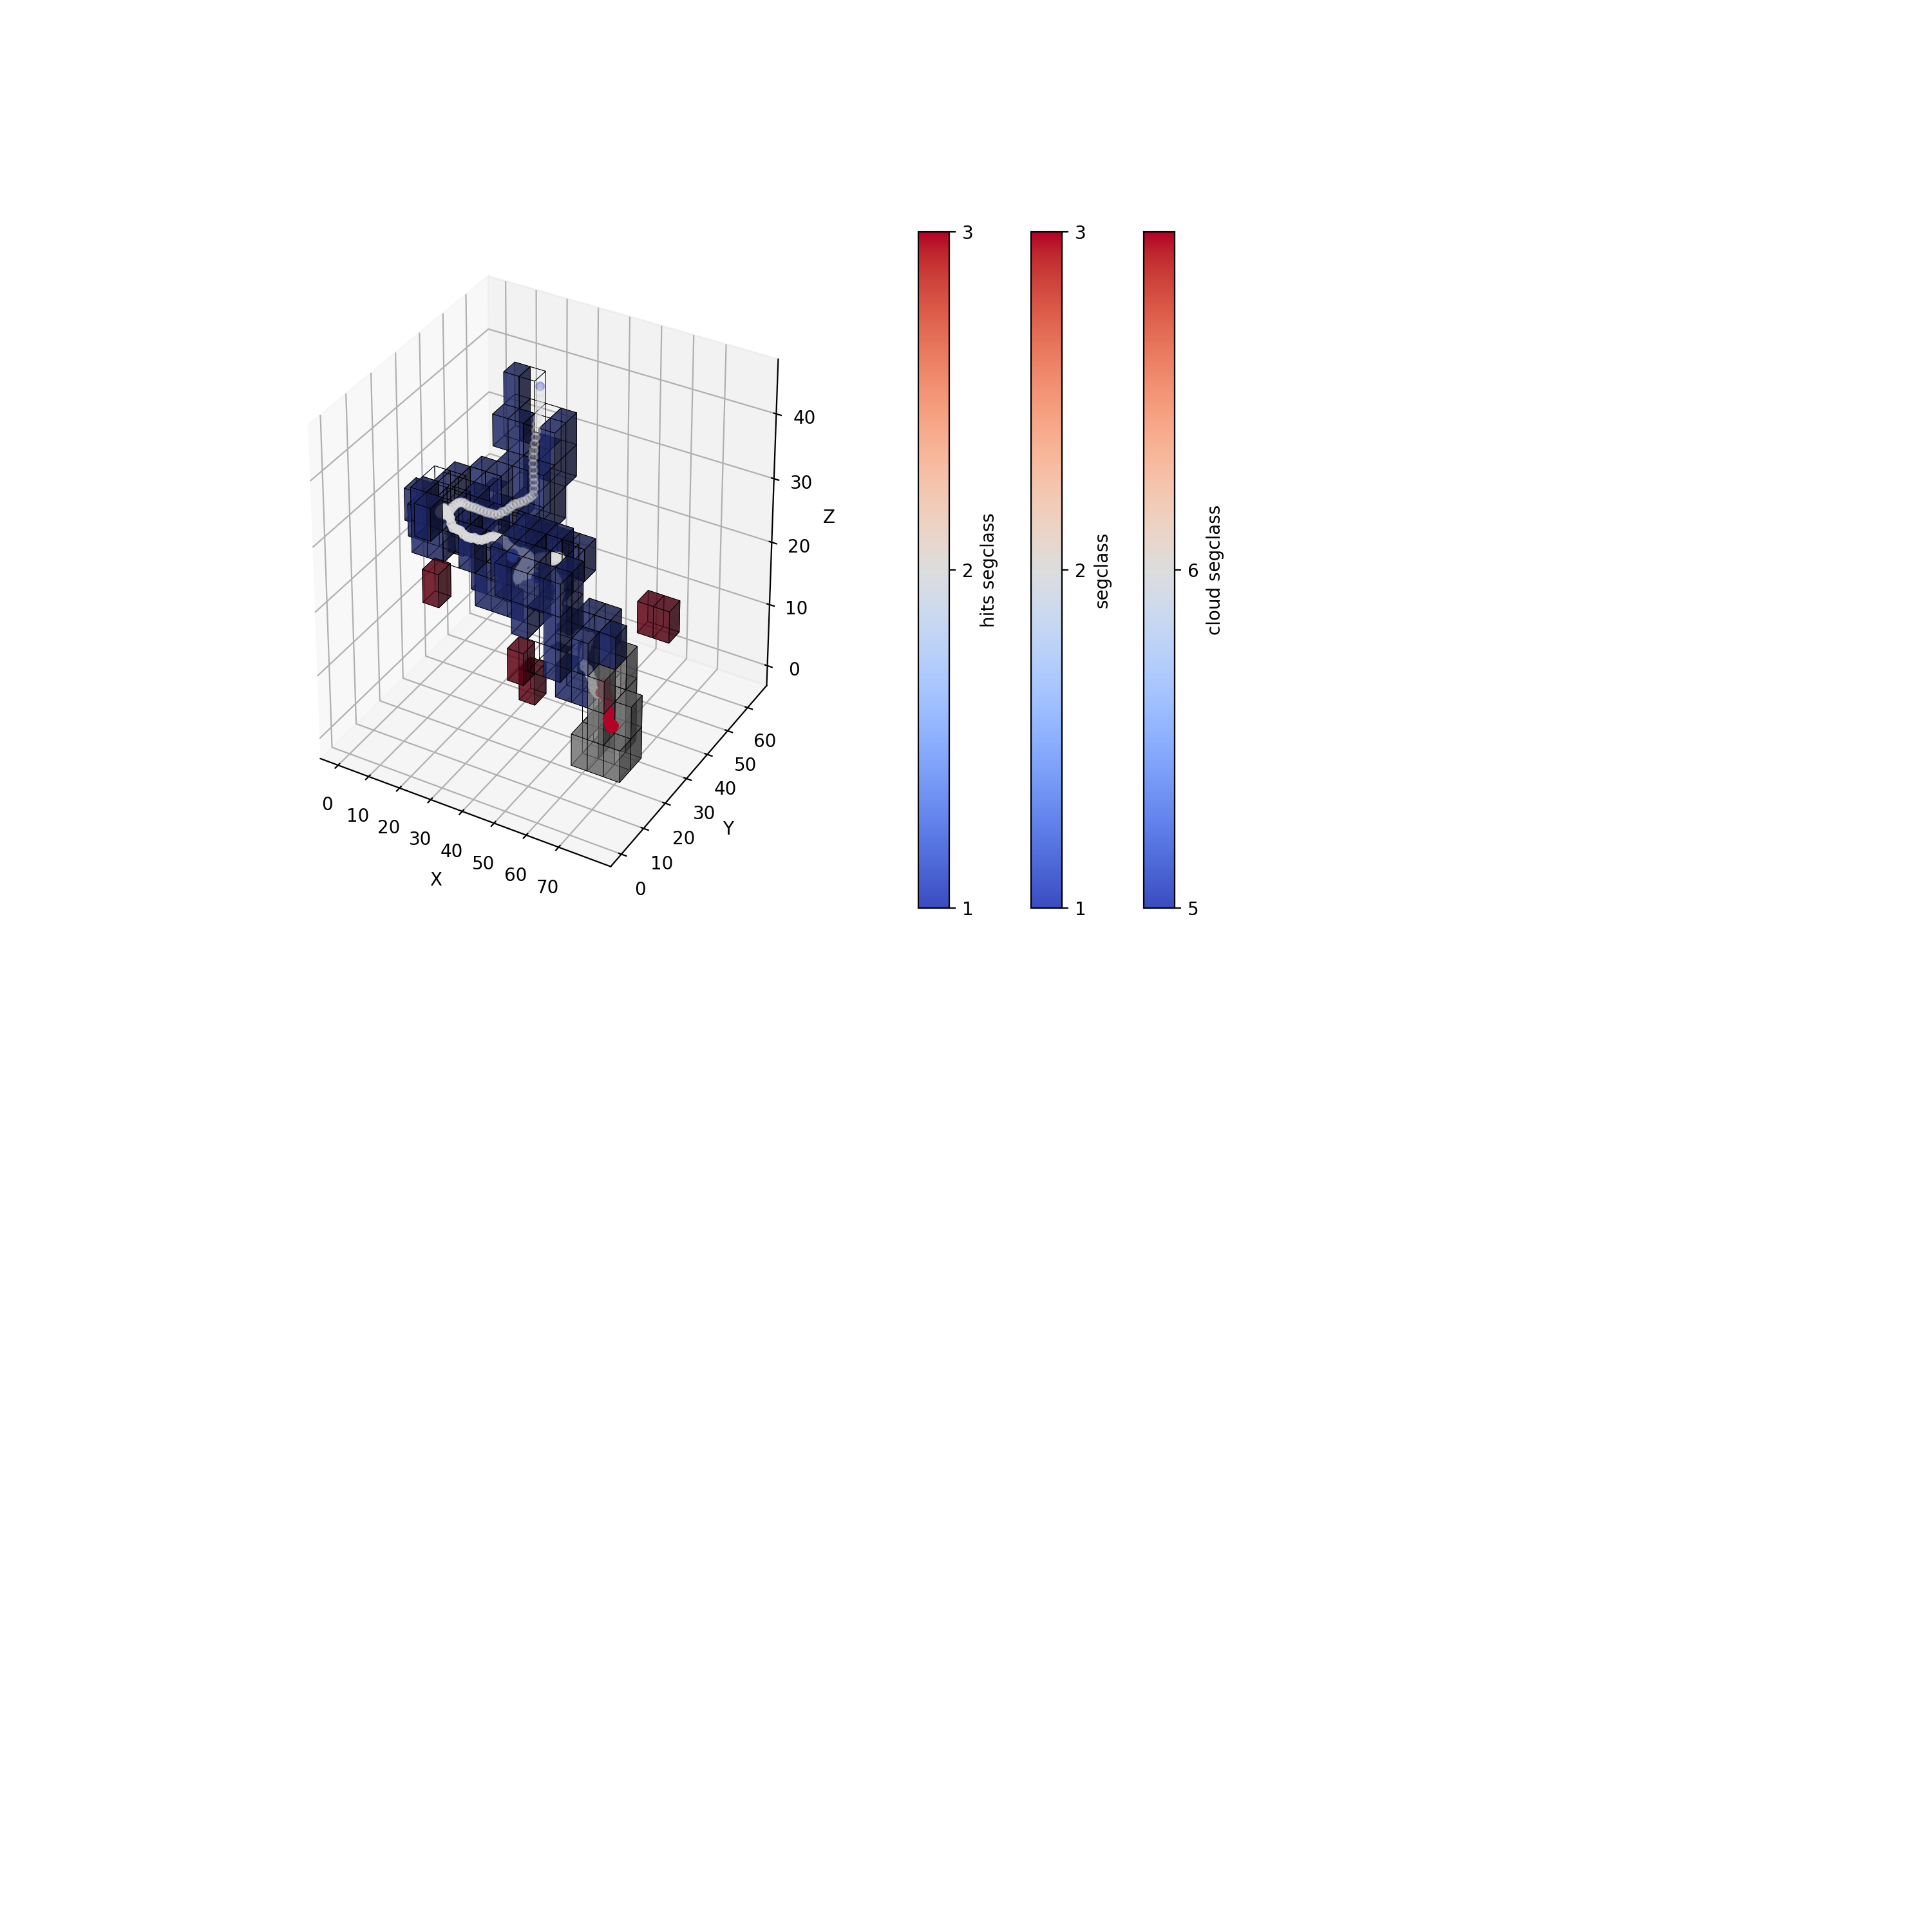

In [20]:
%matplotlib notebook

plot_cloud_voxels(event_beersh, voxel_size, opacity = [1, 0.5], ghost_plot=True)
plot_cloud_voxels_and_hits(event_beersh, event_hits, voxel_size, opacity = [0, 0.6])